In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset.mask_functions import rle2mask, mask2rle
from dataset.dataset import prepare_trainset, build_mask
from utils.utils import save_checkpoint, load_checkpoint, set_logger
from utils.gpu_utils import set_n_get_device

%matplotlib inline

In [2]:
device = set_n_get_device("2", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None #[0, 1]#use 2 gpus

SEED = 1234 #5678#4567#3456#2345#1234
debug = True # if True, load 100 samples
IMG_SIZE = (512, 768)
BATCH_SIZE = 8
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

In [3]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug, crop=True)

Count images in train/test folder:  5546 3698
Count of trainset (for training):  942
Count of validset (for training):  166


In [4]:
for i, (images, masks) in enumerate(train_dl):
    images = images.to(device=device, dtype=torch.float)
    masks = masks.to(device=device, dtype=torch.float)
    #labels = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)==0).to(device=device, dtype=torch.float) #1 for non-zero-mask
    if i==0:
        break

In [5]:
images.size(), masks.size()

(torch.Size([8, 1, 512, 512]), torch.Size([8, 4, 512, 512]))

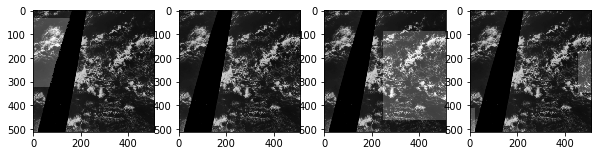

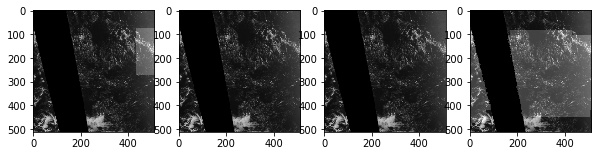

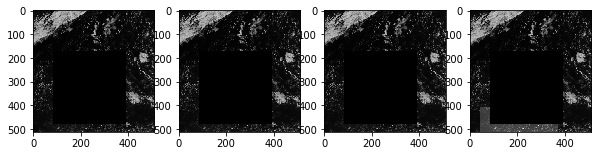

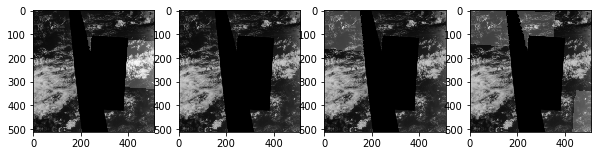

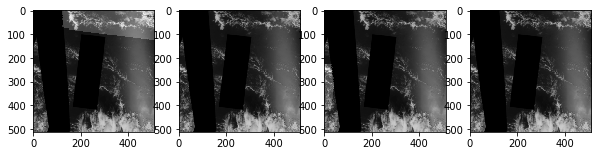

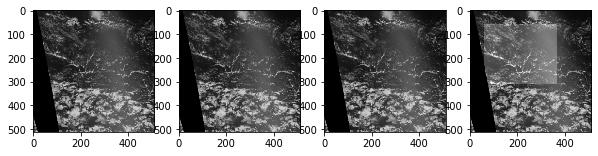

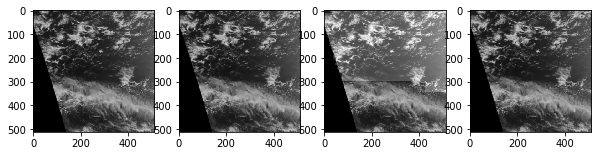

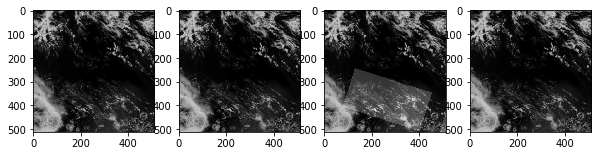

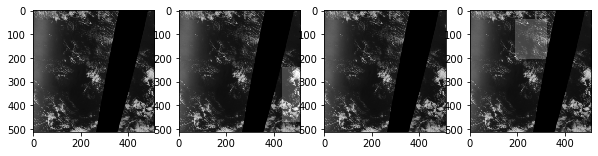

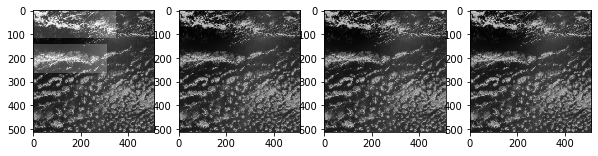

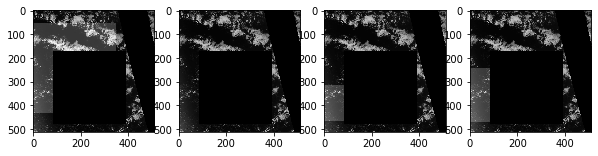

In [6]:
## visualize predicted masks
start = 0
rows = 10

#cmaps = {0: "Reds", 1: "Blues", 2: "Greens", 3: "Oranges"}
titles = {0: "Class=1", 1: "Class=2", 2: "Class=3", 3: "Class=4"}

cnt = 0
for idx, (img, mask) in enumerate(train_dl):
    if idx<start:
        continue
    mask = mask.numpy()
    img = img.numpy()
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        cnt+=1
        fig, axes = plt.subplots(ncols=4, figsize=(10, 8))
        for ch in range(4):
            axes[ch].imshow(img[j][0], cmap='gray')
            axes[ch].imshow(mask[j][ch], cmap='gray', alpha=0.2)
            #axes[ch].set_title('Target')
        if cnt>rows:
            break
    if cnt>rows:
            break

In [ ]:
# from dataset.augmentation import *

# for _ in range(100):
#     img = np.random.randn(256,1600)
#     masks_arr = np.random.randn(4, 256, 1600)

#     img2, masks_arr2 = do_augmentation(img, masks_arr)

#     print(img.shape, masks_arr.shape)
#     print(img2.shape, masks_arr2.shape)
#     print()

## about augmentations

In [ ]:
import sys
sys.path.append('../')

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

from dataset.augmentation import *
from dataset.dataset import mask2rle, build_mask, rle2mask

%matplotlib inline

In [ ]:
fname_list = glob('../data/raw/train/*')
random_fname_list = np.random.choice(fname_list, 10)

len(fname_list), len(random_fname_list)

In [ ]:
# ## visualize augmented images
# mask_data = build_mask()

# for idx, fname in enumerate(random_fname_list):
#     raw_img = plt.imread(fname)[:,:,0]/255
#     masks_in_rle = mask_data[fname.split('/')[-1]]
#     raw_masks_arr = np.array([rle2mask(_mask) for _mask in masks_in_rle])
#     aug_img0, aug_mask0 = do_augmentation(raw_img, raw_masks_arr)
#     aug_img1, aug_mask1 = do_augmentation(raw_img, raw_masks_arr)
#     #aug_img2, aug_mask2 = do_augmentation(raw_img, raw_masks_arr)
    
#     imgs = (raw_img, aug_img0, aug_img1)
#     masks = (raw_masks_arr, aug_mask0, aug_mask1)

#     fig, axes = plt.subplots(ncols=len(imgs), figsize=(15, 8))    
#     for i, ax in enumerate(axes):
#         ax.imshow(imgs[i], cmap='gray')
#         found = False
#         for ch in range(4):
#             if masks[i][ch, :, :].sum()>0:
#                 cmaps = {0: "Reds", 1: "Blues", 2: "Greens", 3: "Oranges"}
#                 titles = {0: "Class=1", 1: "Class=2", 2: "Class=3", 3: "Class=4"}
#                 ax.imshow(masks[i][ch, :, :], cmap=cmaps[ch], alpha=0.2)
#                 ax.set_title(titles[ch])
#                 found = True
#                 break
#         if not found:
#             ax.set_title("Non-Defect")

## test some new augmentation ideas

In [15]:
import sys
sys.path.append('../')

from dataset.mask_functions import rle2mask, mask2rle
from dataset.dataset import prepare_trainset, build_mask
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import copy

%matplotlib inline

In [2]:
mask_data = build_mask()
fnames = list(mask_data.keys())
masks = list(mask_data.values())

In [5]:
def do_shift_scale_crop(image, mask=None, x0=0, y0=0, x1=1, y1=1 ):
    #cv2.BORDER_REFLECT_101
    #cv2.BORDER_CONSTANT

    height, width = image.shape[:2]
    image = image[y0:y1,x0:x1]
    if mask is not None:
        mask  = mask [:,y0:y1,x0:x1]

    image = cv2.resize(image,dsize=(width,height))
    if mask is not None:
        mask = np.array([cv2.resize(arr, dsize=(width,height)) for arr in mask])
        mask  = (mask>0.5).astype(np.float32)
    return image, mask

def do_random_shift_scale_crop_pad2(image, mask=None, limit=0.10):

    H, W = image.shape[:2]

    dy = int(H*limit)
    y0 =   np.random.randint(0,dy)
    y1 = H-np.random.randint(0,dy)

    dx = int(W*limit)
    x0 =   np.random.randint(0,dx)
    x1 = W-np.random.randint(0,dx)

    #y0, y1, x0, x1
    image, mask = do_shift_scale_crop(image, mask, x0, y0, x1, y1 )
    return image, mask

def do_shift_scale_rotate2( image, mask, dx=0, dy=0, scale=1, angle=0 ):
    borderMode=cv2.BORDER_REFLECT_101
    #cv2.BORDER_REFLECT_101  cv2.BORDER_CONSTANT

    height, width = image.shape[:2]
    sx = scale
    sy = scale
    cc = math.cos(angle/180*math.pi)*(sx)
    ss = math.sin(angle/180*math.pi)*(sy)
    rotate_matrix = np.array([ [cc,-ss], [ss,cc] ])

    box0 = np.array([ [0,0], [width,0],  [width,height], [0,height], ],np.float32)
    box1 = box0 - np.array([width/2,height/2])
    box1 = np.dot(box1,rotate_matrix.T) + np.array([width/2+dx,height/2+dy])

    box0 = box0.astype(np.float32)
    box1 = box1.astype(np.float32)
    mat  = cv2.getPerspectiveTransform(box0,box1)

    image = cv2.warpPerspective(image, mat, (width,height),flags=cv2.INTER_LINEAR,
                                borderMode=borderMode,borderValue=(0,0,0,))  #cv2.BORDER_CONSTANT, borderValue = (0, 0, 0))  #cv2.BORDER_REFLECT_101
    mask_rot = []
    for ch in range(mask.shape[0]):
        _mask = mask[ch,:,:]
        _mask = cv2.warpPerspective(_mask, mat, (width,height),flags=cv2.INTER_NEAREST,#cv2.INTER_LINEAR
                                    borderMode=borderMode,borderValue=(0,0,0,))  #cv2.BORDER_CONSTANT, borderValue = (0, 0, 0))  #cv2.BORDER_REFLECT_101
        _mask  = (_mask>0.5).astype(np.float32)
        mask_rot.append(_mask)
    mask_rot = np.array(mask_rot)
    return image, mask_rot

In [84]:
idx = 2

fname = fnames[idx]
print(fname)#, masks[0]

img = cv2.imread('../data/raw/train/'+fname)#defualt read in BGR format
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (768, 512))
#img = img / 255

mask = np.array([cv2.resize(rle2mask(masks[idx][i]), (768, 512)) for i in range(4)])

img.shape, mask.shape

0031ae9.jpg


((512, 768), (4, 512, 768))

In [6]:
img, mask = do_random_shift_scale_crop_pad2(img, mask, limit=0.125)
img, mask = do_shift_scale_rotate2(img, mask, dx=0, dy=0, scale=1, angle=np.random.uniform(0, 10))

img.shape, mask.shape

((512, 768), (4, 512, 768))

(512, 768)


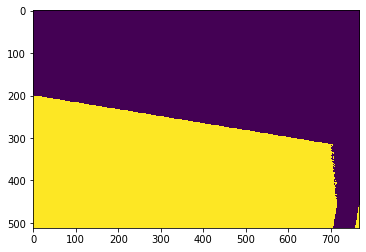

In [7]:
_mask = mask[0]
print(_mask.shape)
plt.imshow(_mask)

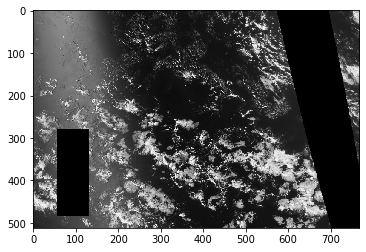

In [87]:
plt.imshow(img, cmap='gray')

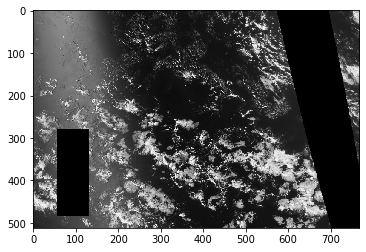

In [88]:
plt.imshow(_img, cmap='gray')

## what is the histogram of pixels area?

In [ ]:
mask_data = build_mask()

In [ ]:
mask_pixel_list = {1:[], 2:[], 3:[], 4:[]}

for idx,(img_id,masks) in enumerate(tqdm_notebook(mask_data.items())):
    #if idx>10:
    #    break
    #print(img_id)
    for cls,mask in enumerate(masks):
        if mask=='':
            continue
        else:
            mask_arr = rle2mask(mask)
            mask_pixel_list[cls+1].append(mask_arr.sum())

In [ ]:
mask_arr.shape

In [ ]:
cls=2

fig = plt.hist(mask_pixel_list[cls])
text = plt.title('class=%d'%cls)

In [ ]:
(np.array(mask_pixel_list[cls])<10000).mean()

In [ ]:
h,w = 256, 1600
400*(h/256)*(w/1600)